In [1]:
import os
import csv



import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

from torchsummary import summary

# Set environment variables for PyTorch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify which GPU to use, if needed

# PyTorch does not have direct equivalents for some TensorFlow environment settings,
# but you can manage GPU memory growth and logging through PyTorch's API.

# Disable debug information (PyTorch does not have a direct equivalent, but you can manage logging)
# PyTorch logging can be managed through Python's logging module or by setting verbosity levels.

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
print(device)

# Print PyTorch version
print(torch.__version__)

# Print number of available GPUs
print("Num GPUs Available: ", torch.cuda.device_count())

# List local devices (PyTorch does not have a direct equivalent, but you can check CUDA devices)
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

cpu
2.6.0+cu126
Num GPUs Available:  1
Device 0: NVIDIA GeForce RTX 4090


In [2]:
import cv2
import random
import glob
import math

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from models_torch.segformer import SegFormer_B0 as SegFormer

In [3]:
MODEL = "B0"
HEIGHT, WIDTH = 1024, 1024
MODEL_NAME = f"{MODEL}_{HEIGHT}x{WIDTH}"

NUM_OF_IMAGES = 40
NUM_OF_VAL_IMAGES = 40

N_STAGES = 3

BATCH_SIZE = 4
ACCUMULATION_STEPS = 8

dir_root = os.path.abspath("./Datasets/shoes/")

dir_img = os.path.join(dir_root, "images_2D/images/")
dir_mask = os.path.join(dir_root, "images_2D/masks/")
dir_model = os.path.join(dir_root, "logs/")

class_dict = {"Karton": 1, "Außensohle": 2, "Innensohle": 3, "Obermaterial": 4, "Zunge": 5, "Füllmaterial": 6}
# class_dict = {"Außensohle": 1, "Innensohle": 2, "Obermaterial": 3, "Füllmaterial": 4}
N_CLASSES = len(class_dict) + 1 # +Background

In [4]:
# due to the different naming of the shoes (images and masks) we have to create a dict to map the images to an unique id

shoe_img_dict = {"Adidas_Martin-weiss": 1, "Adidas_Martin": 2, 
                 "Bruschi_down2_2_2": 3, "Camper_down2_2_2": 4, 
                 "Citywalk-sit-taupe-34_down2_2_2": 5, "Citywalk-sit-taupe-36_down2_2_2": 6, 
                 "Citywalk-sit-taupe-39_down2_2_2": 7, "Citywalk-sit-taupe-40_down2_2_2": 8, 
                 "Citywalk-sit-taupe-42_down2_2_2": 9, "Herrenschuh_43p5_down2_2_2": 10, 
                 "Lidl_43_down2_2_2": 11, "Lloyd_38_down2_2_2": 12, 
                 "Lloyd_pink_down2_2_2": 13, "Lloyd_weiss_down2_2_2": 14, 
                 "McKinley_Anton_down2_2_2": 15, "Mustang-Sch-Navy-Metalli-35_down2_2_2": 16, 
                 "Mustang-Sch-Navy-Metalli-40_down2_2_2": 17, "Mustang-Sch-Navy-Metalli_31_down2_2_2": 18, 
                 "Mustang-Sch-Navy-Metalli_36_down2_2_2": 19, "Mustang-Sch-Navy-Metalli_37_down2_2_2": 20, 
                 "Pertolio-dunkelbraun_43_down2_2_2": 21, "Petrolio-Sch-dunkelbraun_42_down2_2_2": 22, 
                 "Petrolio-Sch-dunkelbraun_44_down2_2_2": 23, "Petrolio-Sch-dunkelbraun_46_down2_2_2": 24,
                 "PetrolioSch-40-float_down2_2_2": 25, "Puma_38_down2_2_2": 26, 
                 "Puma_Silver_down2_2_2": 27, "Puma_White_down2_2_2": 28, 
                 "Schuh_Martin_down2_2_2": 29, "Shoepassion_40_down2_2_2": 30, 
                 "Shoepassion_45_down2_2_2": 31, "Shoepassion_Herren_40_down2_2_2": 32, 
                 "Sneaker_Dana_Nike": 33, "Sneaker_Dana_Puma_Flyer": 34, 
                 "Stiefel-XY_40_down2_2_2": 35, "Tamaris-Pump-Schwarz-38_down2_2_2": 36, 
                 "Tamaris-Pump-schwarz_36_down2_2_2": 37, "Tamaris-Pump-Schwarz_39_down2_2_2": 38, 
                 "Tamaris-Pump-schwarz_40_down2_2_2": 39, "Tamaris-Pump-schwarz_42_down2_2_2": 40}

shoe_mask_dict = {"Adidas_Martin-weiss": 1, "Adidas_Martin": 2, 
                  "Bruschi_down2_2_2": 3, "Camper_down2_2_2": 4, 
                  "Citywalk 34": 5, "Citywalk 36": 6, 
                  "Citywalk 39": 7, "Citywalk 40": 8, 
                  "Citywalk 42": 9, "Herrenschuh_43p5_down2_2_2": 10, 
                  "Lidl_43_down2_2_2": 11, "Lloyd_38_down2_2_2": 12, 
                  "Lloyd_pink_down2_2_2": 13, "Lloyd_weiss_down2_2_2": 14, 
                  "McKinley_Anton": 15, "Mustang 35": 16, 
                  "Mustang 40": 17, "Mustang 31": 18, 
                  "Mustang 36": 19, "Mustang 37": 20, 
                  "Petrolio 43": 21, "Petrolio 42": 22, 
                  "Petrolio 44": 23, "Petrolio 46": 24, 
                  "Petrolio 40": 25, "Puma_38_down2_2_2": 26, 
                  "Puma_Silver_down2_2_2": 27, "Puma_White_down2_2_2": 28, 
                  "Schuh_Martin_down2_2_2": 29, "Shoepassion_40_down2_2_2": 30, 
                  "Shoepassion_45_down2_2_2": 31, "Shoepassion_Herren_40_down2_2_2": 32, 
                  "Sneaker_Dana_Nike": 33, "Sneaker_Dana_Puma_Flyer": 34, 
                  "StiefelXY": 35, "TamarisPump 38": 36,
                  "TamarisPump 36": 37, "TamarisPump 39": 38, 
                  "TamarisPump 40": 39, "TamarisPump 42": 40}

In [5]:
class DataGenerator(Dataset):
    def __init__(self, dir_img, dir_mask, filenames, height=None, width=None, **kwargs):
        super(DataGenerator, self).__init__(**kwargs)
        self.dir_img = dir_img
        self.dir_mask = dir_mask
        self.filenames = filenames
        self.height = height
        self.width = width
        self.datalen = len(filenames)
        self.indexes = np.arange(self.datalen)
        
        
    def load_image(self, dir_img, dir_mask, file, height=None, width=None):
        image = None
        mask = None
        filename_mask = None

        image_path = os.path.join(dir_img, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.
        if height is not None or width is not None:
            image = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)
        height, width = image.shape[:2]
        
        key = file.split("_layer")[0]
        if key in shoe_img_dict:
            id = shoe_img_dict[key]
            for key, value in shoe_mask_dict.items():
                if value == id:
                    filename_mask = key
                    break   
                
        for idx in class_dict:
            mask_filename = os.path.basename(filename_mask + "_" + idx)
            files = [f for f in os.listdir(dir_mask) if f.startswith(mask_filename)] # for the moment there should be only one file in the directory -> files[0] (will take the first in the list ...)
            m = cv2.imread(os.path.join(dir_mask, files[0]), cv2.IMREAD_GRAYSCALE) 
            m = cv2.resize(m, (width, height), interpolation=cv2.INTER_NEAREST) # i.e. StiefelXY: original image and masks have different sizes (968x1130) vs (971x1101) ...
            m = np.clip(m, 0, 1)
            m = (m > 0).astype(np.uint8) * class_dict[idx]  # Convert to binary and assign label
                        
            if mask is None:
                mask = np.zeros_like(m, dtype=np.uint8)
                
            mask[m > 0] = m[m > 0]  # Assign label where mask is not zero!
            
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)
        
        return image, mask
            

    def __getitem__(self, index):
        filename = self.filenames[index]
        X, y = self.load_image(dir_img=self.dir_img, dir_mask=self.dir_mask, file=filename, height=self.height, width=self.width)
        return X, y
    
    
    def __len__(self):
        return self.datalen

In [6]:
train_filenames = os.listdir(dir_img)
print(train_filenames)

# train_gen = DataGenerator(train_folder)
train_gen = DataGenerator(dir_img=dir_img, dir_mask=dir_mask, filenames=train_filenames, height=HEIGHT, width=WIDTH)
val_gen = DataGenerator(dir_img=dir_img, dir_mask=dir_mask, filenames=train_filenames, height=HEIGHT, width=WIDTH)

train_dataloader = DataLoader(train_gen, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_gen, batch_size=BATCH_SIZE, shuffle=False)

imgs, segs = next(iter(train_dataloader))

print(imgs.shape, segs.shape)
print(np.unique(segs))

['Adidas_Martin-weiss_layer_287.png', 'Adidas_Martin_layer_494.png', 'Bruschi_down2_2_2_layer_217.png', 'Camper_down2_2_2_layer_141.png', 'Citywalk-sit-taupe-34_down2_2_2_layer_533.png', 'Citywalk-sit-taupe-36_down2_2_2_layer_535.png', 'Citywalk-sit-taupe-39_down2_2_2_layer_509.png', 'Citywalk-sit-taupe-40_down2_2_2_layer_489.png', 'Citywalk-sit-taupe-42_down2_2_2_layer_466.png', 'Herrenschuh_43p5_down2_2_2_layer_249.png', 'Lidl_43_down2_2_2_layer_205.png', 'Lloyd_38_down2_2_2_layer_249.png', 'Lloyd_pink_down2_2_2_layer_209.png', 'Lloyd_weiss_down2_2_2_layer_168.png', 'McKinley_Anton_down2_2_2_layer_535.png', 'Mustang-Sch-Navy-Metalli-35_down2_2_2_layer_466.png', 'Mustang-Sch-Navy-Metalli-40_down2_2_2_layer_466.png', 'Mustang-Sch-Navy-Metalli_31_down2_2_2_layer_443.png', 'Mustang-Sch-Navy-Metalli_36_down2_2_2_layer_443.png', 'Mustang-Sch-Navy-Metalli_37_down2_2_2_layer_484.png', 'Pertolio-dunkelbraun_43_down2_2_2_layer_402.png', 'Petrolio-Sch-dunkelbraun_42_down2_2_2_layer_322.png', 'P

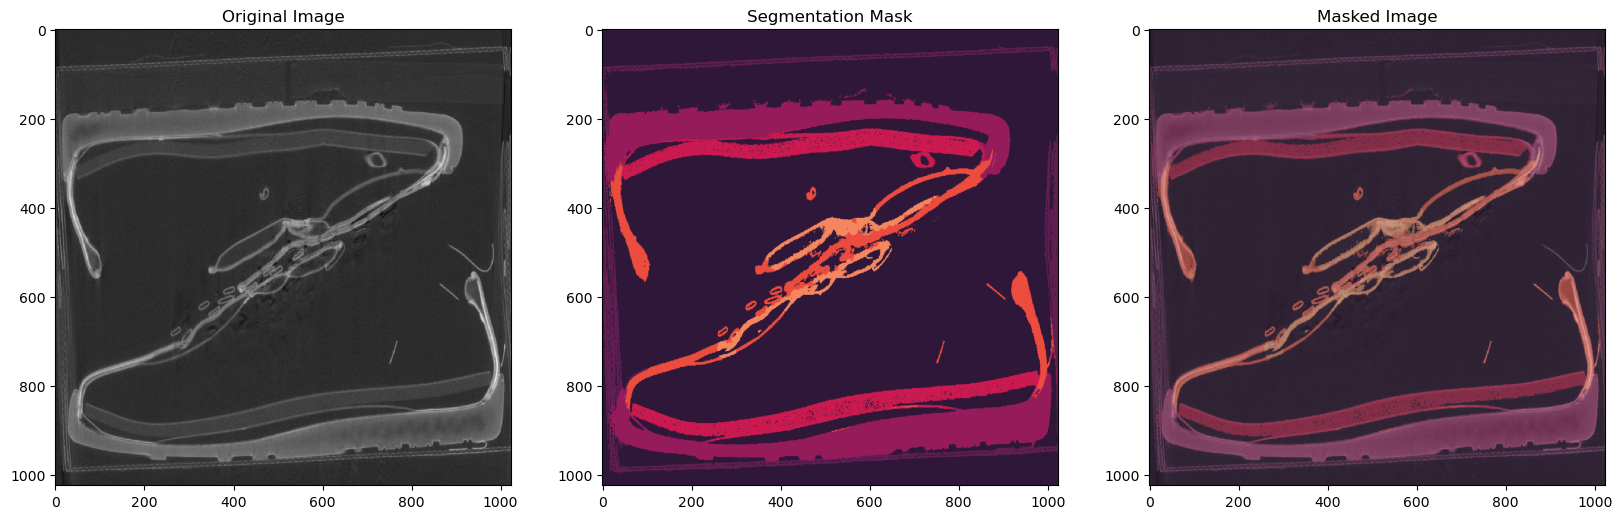

In [7]:
def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    # Initialize a tensor for the colored segmentation image with channels first
    seg_img = torch.zeros((3, seg.shape[1], seg.shape[2]), dtype=torch.float32)
    # colors = sns.color_palette("hls", n_classes)
    colors = sns.color_palette("rocket", n_classes)
    
    seg = seg.squeeze(0) 
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[0,:,:] += segc * colors[c][0]
        seg_img[1,:,:] += segc * colors[c][1]
        seg_img[2,:,:] += segc * colors[c][2]

    return(seg_img)

image = imgs.to("cpu")
mask = segs.to("cpu")

idx = 0
image = image[idx].squeeze(0)
mask = mask[idx]
mask = give_color_to_seg_img(mask)

# Convert tensors to numpy arrays for visualization
image_np = image.numpy()  
mask_np = mask.permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C)

# Convert tensors to numpy arrays for visualization
masked_image_np = np.stack([image_np] * 3, axis=-1) * 0.5 + mask_np * 0.5

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title('Original Image')
axs[1].imshow(mask_np)
axs[1].set_title('Segmentation Mask')
axs[2].imshow(masked_image_np)
axs[2].set_title('Masked Image')
plt.show()

In [8]:
model = SegFormer(input_shape=(1, HEIGHT, WIDTH), num_stages=3, num_classes=N_CLASSES)

model = model.to(device) # Move the model to the appropriate device (GPU if available)
imgs = imgs.to(device)
model_output = model(imgs) # <------ error when device="cuda"

# summary(model, input_size=(3, HEIGHT, WIDTH))

In [9]:
# Iterate over the layers of the model
for name, layer in model.named_children():
    print(f"Layer: {name}")
    print(f"  Type: {layer.__class__.__name__}")
    
    for param_name, param in layer.named_parameters(recurse=False):
        print(f" Weight dtype: {param.dtype} | Weight name: {param_name} | Shape: {param.shape}")

Layer: mix_vision_transformer
  Type: MixVisionTransformer
Layer: seg_former_head
  Type: SegFormerHead
Layer: resize_layer
  Type: ResizeLayer


In [10]:
# import torch
# from torchviz import make_dot

# # Forward pass through the model to get the graph
# model_output = model(imgs)

# # # Generate and save the model graph
# model_graph = make_dot(model_output, params=dict(model.named_parameters()))
# model_graph.render(f"segformer_model_structure_{MODEL_NAME}", format="png")

In [11]:
# Iterate over the layers of the model
for name, layer in model.named_children():
    # Check if the layer has parameters and print their trainability status
    has_trainable_params = any(param.requires_grad for param in layer.parameters(recurse=False))
    print(f"Layer: {name} | Trainable: {has_trainable_params}")

Layer: mix_vision_transformer | Trainable: False
Layer: seg_former_head | Trainable: False
Layer: resize_layer | Trainable: False


In [12]:
# Function to hook and capture output shapes
def hook_fn(module, input, output):
    module.output_shape = output.shape if isinstance(output, torch.Tensor) else [o.shape for o in output]

# Register hooks to capture output shapes
hooks = []
for name, layer in model.named_children():
    hook = layer.register_forward_hook(hook_fn)
    hooks.append(hook)

# Forward pass through the model to trigger hooks
_ = model(imgs)

# Print each layer's output shape
for name, layer in model.named_children():
    output_shape = getattr(layer, "output_shape", "N/A")
    print(f"Layer: {name} | Output Shape: {output_shape}")

# Remove hooks
for hook in hooks:
    hook.remove()

Layer: mix_vision_transformer | Output Shape: [torch.Size([4, 32, 256, 256]), torch.Size([4, 64, 128, 128]), torch.Size([4, 160, 64, 64]), torch.Size([4, 256, 32, 32])]
Layer: seg_former_head | Output Shape: torch.Size([4, 7, 256, 256])
Layer: resize_layer | Output Shape: torch.Size([4, 7, 1024, 1024])


In [13]:
def iou_metric(y_true, y_pred, smooth=1, num_classes=N_CLASSES):
    # Flatten y_true
    y_true = y_true.reshape(-1).float()  # Ensure y_true is float32 and flatten

    # Reshape y_pred to match
    y_pred = y_pred.permute(0, 2, 3, 1).reshape(-1,num_classes).float()  # (batch_size * height * width, num_classes)

    iou_per_class = []
    for class_id in range(num_classes):
        true_mask = (y_true == class_id).float()  # Binary mask for class
        pred_mask = y_pred[:, class_id]  # Softmax probability for class

        intersection = torch.sum(true_mask * pred_mask)
        union = torch.sum(true_mask) + torch.sum(pred_mask) - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)  # Store IoU for each class

    return torch.mean(torch.stack(iou_per_class))

def jaccard_distance_loss(y_true, y_pred, smooth=1, num_classes=N_CLASSES):
    iou = iou_metric(y_true, y_pred, smooth=smooth, num_classes=num_classes)
    return 1 - iou

In [14]:
EPOCHS = [20,1000]
learning_rate = 1e-4


class WarmupSchedulerWithReduceLROnPlateau:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr, 
                 reduce_lr_factor=0.1, min_lr=1e-6, patience=5, monitor='val_loss', mode='min'):

        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.reduce_lr_factor = reduce_lr_factor
        self.patience = patience
        self.min_lr = min_lr
        self.monitor = monitor
        self.mode = mode
        self.epoch = 0
        self.best_metric = np.inf if mode == 'min' else -np.inf
        self.wait = 0
        self.last_epoch_metric_value = None
        self.new_lr = None
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr

    def on_epoch_begin(self, epoch):
        if epoch <= self.warmup_epochs:
            # Linear warm-up
            self.new_lr = self.initial_lr + (self.target_lr - self.initial_lr) * (epoch / self.warmup_epochs)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = self.new_lr
            print(f"Warmup: Setting LR to {self.new_lr:.8f}")
        else:
            for param_group in self.optimizer.param_groups:
                self.new_lr = param_group['lr']
            print(f"Training: LR = {self.new_lr:.8f}")

    def on_epoch_end(self, epoch, logs):
        self.epoch += 1
        metric_value = logs.get(self.monitor)

        if metric_value is None:
            return

        if epoch > self.warmup_epochs:
            if (self.mode == 'min' and metric_value < self.best_metric) or (self.mode == 'max' and metric_value > self.best_metric):
                self.best_metric = metric_value
                self.wait = 0  # Reset patience counter
                print(f"\nwait (after if): {self.wait}")
            else:
                self.wait += 1
                print(f"\nwait (after else): {self.wait}")
                if self.wait >= self.patience:
                    self.new_lr = max(self.new_lr * self.reduce_lr_factor, self.min_lr)
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = self.new_lr
                    print(f"ReduceLROnPlateau: Reducing LR to {self.new_lr:.8f}")
                    self.wait = 0  # Reset patience counter


class EarlyStopping:
    def __init__(self, patience=50, monitor='val_loss', mode='min'):
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.counter = 0
        self.best_metric = np.inf if mode == 'min' else -np.inf
        self.early_stop = False

    def __call__(self, metric_value):
        if self.mode == 'min':
            if metric_value < self.best_metric:
                self.best_metric = metric_value
                self.counter = 0
            else:
                self.counter += 1
        else:
            if metric_value > self.best_metric:
                self.best_metric = metric_value
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            

class CSVLogger:
    def __init__(self, filepath, append=False):
        self.filepath = filepath
        if not append and os.path.isfile(filepath):
            os.remove(filepath)
        self.file = open(filepath, 'a', newline='')
        self.writer = csv.writer(self.file)
        self.write_header = True

    def log(self, epoch, logs):
        if self.write_header:
            self.writer.writerow(['epoch'] + list(logs.keys()))
            self.write_header = False
        self.writer.writerow([epoch] + list(logs.values()))

    def close(self):
        self.file.close()
        
        
class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best_value = None
        if self.mode == 'min':
            self.best_value = np.inf
        else:
            self.best_value = -np.inf

    def __call__(self, model, monitor_value):
        if not self.save_best_only:
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"Model saved to {self.filepath}")
            return

        if self.mode == 'min':
            if monitor_value < self.best_value:
                self.best_value = monitor_value
                torch.save(model.state_dict(), self.filepath)
                if self.verbose:
                    print(f"Model improved, saving to {self.filepath}")
        else:
            if monitor_value > self.best_value:
                self.best_value = monitor_value
                torch.save(model.state_dict(), self.filepath)
                if self.verbose:
                    print(f"Model improved, saving to {self.filepath}")

In [15]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Start with small LR

# scheduler = WarmupSchedulerWithReduceLROnPlateau(optimizer=optimizer, warmup_epochs=EPOCHS[0], 
#                                                  initial_lr=1e-8, target_lr=learning_rate, reduce_lr_factor=0.5, min_lr=1e-8,
#                                                  patience=15, monitor='val_loss', mode='min')

# early_stopping = EarlyStopping(patience=50, monitor='val_loss', mode='min')
# csv_logger = CSVLogger(filepath=f"{MODEL_NAME}_training.log", append=False)
# checkpoint = ModelCheckpoint(filepath=f"seg_model_{MODEL_NAME}.pth", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
max_grad_norm = 1.0

for epoch in range(EPOCHS[1]):
    
    train_iou, train_loss = 0, 0
    model.train()  # Set the model to training mode
    for batch_idx, (imgs, segs) in enumerate(train_dataloader):
        imgs = Variable(imgs).to(device)
        segs = Variable(segs).to(device)
        
        output = model(imgs)#, training=True)
        print(output.shape)
        loss = jaccard_distance_loss(segs, output)
        train_loss += loss.item()
        print("after loss: ", loss)
        # loss.backward(inputs=tuple(model.parameters()), retain_graph=True) # <------------------ ????
        loss.backward() # <------------------ ????
        print("after backward")
        
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
            clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            optimizer.zero_grad()        
    
    
    # Validation phase
    val_iou, val_loss = 0, 0
    # model.eval()  # Set the model to evaluation mode
    # with torch.no_grad():
    #     for imgs, segs in val_dataloader:
    #         output = model(imgs, training=False)
    #         loss = jaccard_distance_loss(segs, output)
    #         val_loss += loss.item()
    #         val_iou += (1.0 - loss.item())
    print(f"Epoch {epoch + 1}, iou: {train_iou:.4f}, loss: {train_loss:.4f}, val_iou: {val_iou:.4f}, val_loss: {val_loss:.4f}")

torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9566, grad_fn=<RsubBackward1>)
after backward
torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9570, grad_fn=<RsubBackward1>)
after backward
torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9632, grad_fn=<RsubBackward1>)
after backward
torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9581, grad_fn=<RsubBackward1>)
after backward
torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9627, grad_fn=<RsubBackward1>)
after backward
torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9595, grad_fn=<RsubBackward1>)
after backward
torch.Size([4, 7, 1024, 1024])
after loss:  tensor(0.9599, grad_fn=<RsubBackward1>)


In [ ]:
# will be done later ...
# bestmodel = SegFormer(input_shape=(1, HEIGHT, WIDTH), num_stages=3, num_classes=N_CLASSES)
# bestmodel.load_weights("./seg_model_" + MODEL_NAME + ".keras")

bestmodel = model

test_gen = DataGenerator(dir_img=dir_img, dir_mask=dir_mask, filenames=train_filenames, height=HEIGHT, width=WIDTH)
test_dataloader = DataLoader(test_gen, batch_size=1, shuffle=False)

In [ ]:
test_iter = iter(test_dataloader)

#
# to be checked later !!
#

for i in range(8):
    imgs, segs = next(test_iter)
    print(imgs.shape, segs.shape)
    pred = bestmodel.predict(imgs)
    
    _p = give_color_to_seg_img(np.argmax(pred[0], axis=-1)) # to be checked later 
    _s = give_color_to_seg_img(segs[0])

    predimg = cv2.addWeighted(imgs[0], 0.15, _p, 0.85, 0)
    trueimg = cv2.addWeighted(imgs[0], 0.15, _s, 0.85, 0)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Original")
    plt.imshow(imgs[0])
    plt.axis("off")
    
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(133)
    plt.title("Ground truth")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()